In [48]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from collections import OrderedDict
import json
from keras.models import model_from_json
%matplotlib inline

In [11]:
def load_results(file_name):
    
    # dataset, size, data_aug, val acc, val err
    results= np.array(["", "", "", "", ""])
        
    for size in [100, 75, 50, 25, 10, 1]:
        for exp_clot, exp_face in zip([0,1], [2,3]):        
            file_face = "{:d}_model_1_faces_{:d}.txt".format(exp_face, size)
            file_clot = "{:d}_model_1_clothes_{:d}.txt".format(exp_clot, size)
            
            hyper_face = get_hyper(file_face)
            hyper_clot = get_hyper(file_clot)
            
            top_line = ""
            face_line = ""
            clot_line = ""
            
            row_face = np.array([])
            row_clot = np.array([])
            for key, key2 in zip(hyper_face, hyper_clot):
                
                if key not in ["dataset_type", "vAcc", "vErr", "data_augmentation", "dataset_size"]:
                    continue
                
                row_face = np.hstack((row_face, (str)(hyper_face[key])))
                row_clot = np.hstack((row_clot, (str)(hyper_clot[key])))
                                
            results = np.vstack((results, row_face, row_clot))
    
    np.savetxt(file_name, results[1:,:],  fmt='%s')

def get_hyper(file_name):
    with open(file_name, 'r') as f:
        hyper_line = f.readline()
    
    key_values = hyper_line.split(",")
    
    hyper = OrderedDict()
    
    for kv in key_values:
        key_val = kv.split(":")
        key = key_val[0].strip()
        try:
            val = (float)(key_val[1])
        except:
            val = (str)(key_val[1])
        
        hyper[key] = val
    
        
    # get val accuracy and error in last epoch
    epochs = np.genfromtxt(file_name, np.float32, delimiter=",", skip_header=2).astype(float)
    val_acc = epochs[-1,1]
    val_err = epochs[-1,0]
    
    hyper["vAcc"] = val_acc
    hyper["vErr"] = val_err
    if hyper['dataset_type'] == 1:
        hyper["dataset_type"] = "clothes"
        
    if hyper["dataset_type"] == 2:
        hyper["dataset_type"] = "faces"
        
    return hyper

load_results("exp_sebastian.txt")

/mnt/linux_shared/shared/anaconda3/envs/mlp/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


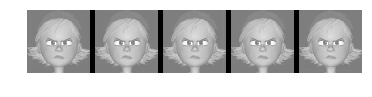

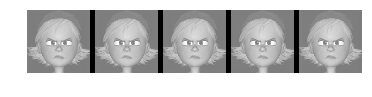

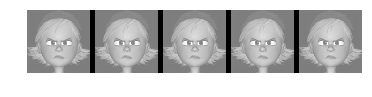

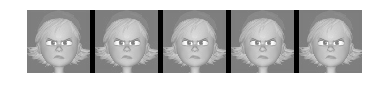

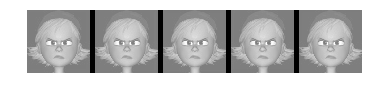

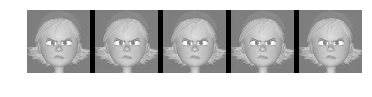

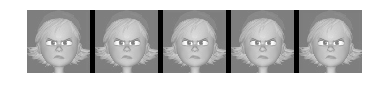

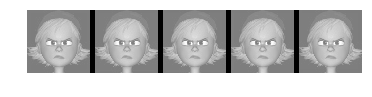

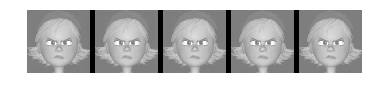

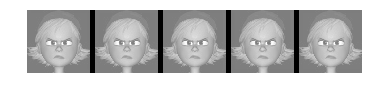

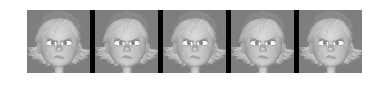

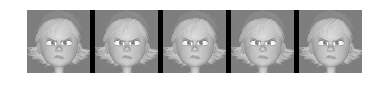

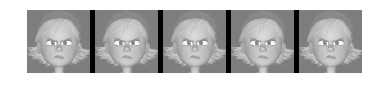

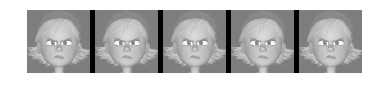

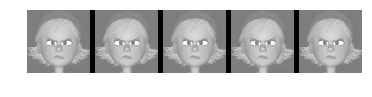

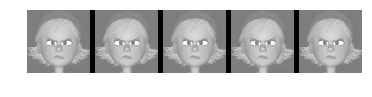

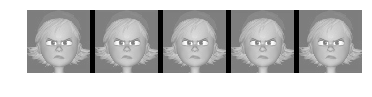

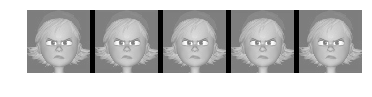

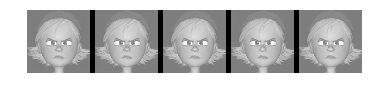

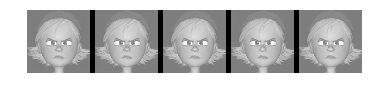

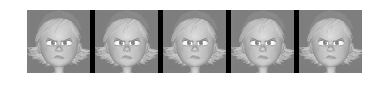

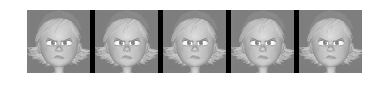

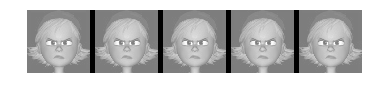

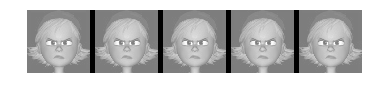

In [112]:
'''Visualization of the filters of VGG16, via gradient ascent in input space.
This script can run on CPU in a few minutes.
Results example: http://i.imgur.com/4nj4KjN.jpg
'''
from __future__ import print_function

from scipy.misc import imsave
import numpy as np
import time
from keras.applications import vgg16
from keras import backend as K

# dimensions of the generated pictures for each filter.
img_width = 64
img_height = 64

# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
layer_name = 'convolution'

# util function to convert a tensor into a valid image

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def process_filters(weights_file_name):
    # build the VGG16 network with ImageNet weights
    #model = vgg16.VGG16(weights='imagenet', include_top=False)
    with open("baseline_model.json", 'r') as jfile:
        # NOTE: if you saved the file by calling json.dump(model.to_json(), ...)
        # then you will have to call:
        #
        model = model_from_json(json.loads(jfile.read()))\
        #
        # instead.
    #model = model_from_json(jfile.read())
    model.compile("adam", "categorical_crossentropy")
    model.load_weights(weights_file_name + ".hdf")
#     print('Model loaded.')

    #model.summary()

    # this is the placeholder for the input images
    input_img = model.input

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])


    def normalize(x):
        # utility function to normalize a tensor by its L2 norm
        return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


    kept_filters = []
    for filter_index in range(5):
        # we only scan through the first 200 filters,
        # but there are actually 512 of them
#         print('Processing filter %d' % filter_index)
        start_time = time.time()

        # we build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        layer_output = layer_dict[layer_name].output
        if K.image_data_format() == 'channels_first':
            loss = K.mean(layer_output[:, filter_index, :, :])
        else:
            loss = K.mean(layer_output[:, :, :, filter_index])

        # we compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, input_img)[0]

        # normalization trick: we normalize the gradient
        grads = normalize(grads)

        # this function returns the loss and grads given the input picture
        iterate = K.function([input_img], [loss, grads])

        # step size for gradient ascent
        step = 1.

        # we start from a gray image with some random noise
        if K.image_data_format() == 'channels_first':
            input_img_data = np.random.random((1, 1, img_width, img_height))
        else:
            input_img_data = np.random.random((1, img_width, img_height, 1))

        input_img_data = cv2.imread("../data/faces/test/0/0.jpg", cv2.IMREAD_GRAYSCALE).reshape((1, img_width, img_height, 1))
        input_img_data = (input_img_data - 0.5) * 20 + 128
    #     input_img_data = input_img_data/127.5 - 1
    #     input_img_data = np.zeros_like(input_img_data)

        # we run gradient ascent for 20 steps
        for i in range(20):
            loss_value, grads_value = iterate([input_img_data])
            input_img_data += grads_value * step

    #         print('Current loss value:', loss_value)
    #         if loss_value <= 0.:
    #             # some filters get stuck to 0, we can skip them
    #             break

        # decode the resulting input image
        #if loss_value > 0:
        img = deprocess_image(input_img_data[0])

    #     input_img_data = input_img_data * 255
    #     img = input_img_data
        kept_filters.append((img, loss_value))
        end_time = time.time()
#         print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

    # we will stich the best 64 filters on a 8 x 8 grid.
    n = 5

    # the filters that have the highest loss are assumed to be better-looking.
    # we will only keep the top 64 filters.
    #kept_filters.sort(key=lambda x: x[1], reverse=True)
    #kept_filters = kept_filters[:n]

    # build a black picture with enough space for
    # our 8 x 8 filters of size 128 x 128, with a 5px margin in between
    margin = 5
    width = img_width
    height = n * img_height + (n - 1) * margin
    stitched_filters = np.zeros((width, height, 1))

    # fill the picture with our saved filters
    for i in range(n):
        img, loss = kept_filters[i]
        stitched_filters[:,
                         (img_height + margin) * i: (img_height + margin) * i + img_height] = img

    # save the result to disk
    plt.figure()
    plt.imshow(stitched_filters.squeeze(), cmap="gray")
    plt.axis("off")
    #imsave('stitched_filters_%dx%d.png' % (n, n), stitched_filters)
    
process_filters("0_model_1_clothes_100")
process_filters("1_model_1_clothes_100")
process_filters("0_model_1_clothes_75")
process_filters("1_model_1_clothes_75")
process_filters("0_model_1_clothes_50")
process_filters("1_model_1_clothes_50")
process_filters("0_model_1_clothes_25")
process_filters("1_model_1_clothes_25")
process_filters("0_model_1_clothes_10")
process_filters("1_model_1_clothes_10")
process_filters("0_model_1_clothes_1")
process_filters("1_model_1_clothes_1")

process_filters("2_model_1_faces_100")
process_filters("2_model_1_faces_100")
process_filters("2_model_1_faces_75")
process_filters("2_model_1_faces_75")
process_filters("2_model_1_faces_50")
process_filters("2_model_1_faces_50")
process_filters("2_model_1_faces_25")
process_filters("2_model_1_faces_25")
process_filters("2_model_1_faces_10")
process_filters("2_model_1_faces_10")
process_filters("2_model_1_faces_1")
process_filters("2_model_1_faces_1")

In [102]:
with open("baseline_model.json", 'r') as jfile:
    # NOTE: if you saved the file by calling json.dump(model.to_json(), ...)
    # then you will have to call:
    #
    model = model_from_json(json.loads(jfile.read()))\
    #
    # instead.
#model = model_from_json(jfile.read())
model.compile("adam", "categorical_crossentropy")
model.load_weights("1_model_1_clothes_100.hdf")
print('Model loaded.')


model.layers[1].get_weights()

Model loaded.


[array([[[[ 0.04054469,  0.01201952, -0.0378304 ,  0.08612604,  0.09148747]],
 
         [[ 0.01715651,  0.00606951, -0.02062918,  0.12663886,  0.02718296]],
 
         [[ 0.03723433, -0.03095465, -0.00097518,  0.03392119, -0.05216162]],
 
         [[ 0.07162455, -0.00671827, -0.04762151, -0.05429137, -0.05713922]],
 
         [[ 0.08550917, -0.06217991, -0.04279372, -0.07038698, -0.12742704]]],
 
 
        [[[-0.00105725, -0.0058006 ,  0.02776139, -0.01186956,  0.15812337]],
 
         [[-0.00807953,  0.00320411,  0.00376164,  0.07220034,  0.05796743]],
 
         [[-0.02693777, -0.03397423, -0.04366359,  0.02724733,  0.00890708]],
 
         [[-0.0005303 , -0.03372172, -0.05663566, -0.00766164, -0.12632905]],
 
         [[ 0.05427368, -0.02498783, -0.06971427, -0.09578466, -0.12209806]]],
 
 
        [[[-0.09000671, -0.0746408 , -0.02460643, -0.08175351,  0.16700728]],
 
         [[-0.01278092, -0.06643557,  0.00192907,  0.03781817,  0.0609238 ]],
 
         [[-0.04305371, -0.0082195